# CS146 Assignment 2
## Armin Hamp, 2019 September 27

# Code from previous class

Below I kept only the code from Activity 2.2 that is essential for completing Assignment 2.

In [1]:
import numpy as np
import scipy as sp
import scipy.stats as sts
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Load the data set containing durations between calls arriving at the call
# center during 1 day. All values are in minutes.
waiting_times_day = np.loadtxt('call_center.csv')

# Display some basic information about the data set.
print('Size of data set:', len(waiting_times_day))
print('First 3 values in data set:', waiting_times_day[:3])
print('Sum of data set:', sum(waiting_times_day))

# Make 24 empty lists, one per hour.
waiting_times_per_hour = [[] for _ in range(24)]

# Split the data into 24 separate series, one for each hour of the day.
current_time = 0
for t in waiting_times_day:
    current_hour = int(current_time // 60)
    current_time += t
    waiting_times_per_hour[current_hour].append(t)

Size of data set: 5856
First 3 values in data set: [30.   3.4  3.2]
Sum of data set: 1441.6838153800093


In [3]:
# THE LIKELIHOOD FUNCTION
#
# This function takes 2 inputs, namely the parameter (λ) value at which to
# compute the likelihood and a value from the data set. You need to evaluate
# the exponential distribution of the datum given the parameter value.

def likelihood(lambda_, datum):
    return sts.expon(scale=1/lambda_).pdf(datum)

# THE PRIOR DISTRIBUTION
#
# This function takes 1 input, namely the parameter value (λ) at which to
# compute the prior probability density. You need to evaluate the distribution
# Gamma(λ | α, β).

def prior(lambda_):
    return sts.gamma(1, scale=1/0.25).pdf(lambda_)

# THE POSTERIOR DISTRIBUTION
#
# The function below is provided to help make computing the posterior easier. It
# follows the same pattern as in the previous class, where we multiple the prior
# and the likelihood evaluated at various values of the parameter (λ).
#
# You will see the function uses the logarithms of various distributions. This
# is for numerical reasons. When you multiply lots of likelihood values, the
# result can become very large or very small, causing numerical overflow or
# underflow in Python. Taking logarithms avoids this problem.

def compute_posterior(parameter_values, prior, likelihood, data):
    log_prior = np.log(prior(parameter_values))
    log_likelihood = np.array([
        np.sum(np.log(likelihood(param, data)))
        for param in parameter_values])
    unnormalized_log_posterior = log_prior + log_likelihood
    unnormalized_log_posterior -= max(unnormalized_log_posterior)
    unnormalized_posterior = np.exp(unnormalized_log_posterior)
    area = sp.integrate.trapz(unnormalized_posterior, parameter_values)
    posterior = unnormalized_posterior / area
    return posterior

In [4]:
def compute_percentile(parameter_values, distribution_values, percentile):
    '''
    Compute the parameter value at a particular percentile of the given
    probability distribution values. This function uses the cumulative trapezoid
    integrator in SciPy.

    Inputs:

        parameter_values (array of float) This is the list of parameter values
          at which the probability distribution has been evaluated.

        distribution_values (array of float) This is the list of values of the
          probability density function evaluated at the parameter values above.

        percentile (float) This is the value between 0 and 1 of the percentile
          to compute.

    Returns: (float) The parameter value at the given percentile.
    '''
    cumulative_distribution = sp.integrate.cumtrapz(
        distribution_values, parameter_values)
    percentile_index = np.searchsorted(cumulative_distribution, percentile)
    return lambdas[percentile_index]

# Own work

Compute a 98% posterior confidence interval over the number of calls per minute (the call
rate λ ) for each hour of the day — so you will have 24 confidence intervals. Also, compute
the posterior mean of λ for each hour of the day.


In [25]:
#calculate and store posteriors for each hour, calculate and store conf ints
#storage vectors for posteriors, ci, means
posteriors=[]
confidence_intervals=[]
posterior_means=[]
for h in range(24):
    #loop through every hour and compute posterio
    lambdas=np.linspace(0, 20, 501)[1:] #initialise lambda
    posteriors.append(compute_posterior(lambdas, prior, likelihood, waiting_times_per_hour[h])) 
    confidence_intervals.append([compute_percentile(lambdas, posteriors[h], p) for p in [0.01, 0.99]])
    posterior_means.append(sp.integrate.trapz(posteriors[h] * lambdas, lambdas))

#print conf ints
print("Confidence Intervals over call rate for each hour of the day")
for i in range(24):
    print("Hour ",i,"  ",confidence_intervals[i])


Confidence Intervals over call rate for each hour of the day
Hour  0    [0.04, 0.2]
Hour  1    [0.04, 0.16]
Hour  2    [0.04, 0.16]
Hour  3    [0.08, 0.44]
Hour  4    [0.24, 0.64]
Hour  5    [0.6, 1.2]
Hour  6    [1.2, 1.96]
Hour  7    [2.36, 3.4]
Hour  8    [3.64, 4.88]
Hour  9    [5.0, 6.44]
Hour  10    [7.4, 9.16]
Hour  11    [14.16, 16.52]
Hour  12    [13.120000000000001, 15.4]
Hour  13    [5.6000000000000005, 7.12]
Hour  14    [2.56, 3.64]
Hour  15    [2.88, 4.0]
Hour  16    [3.7600000000000002, 5.0]
Hour  17    [6.2, 7.76]
Hour  18    [7.92, 9.68]
Hour  19    [5.88, 7.44]
Hour  20    [1.84, 2.7600000000000002]
Hour  21    [0.56, 1.12]
Hour  22    [0.16, 0.52]
Hour  23    [0.12, 0.48]


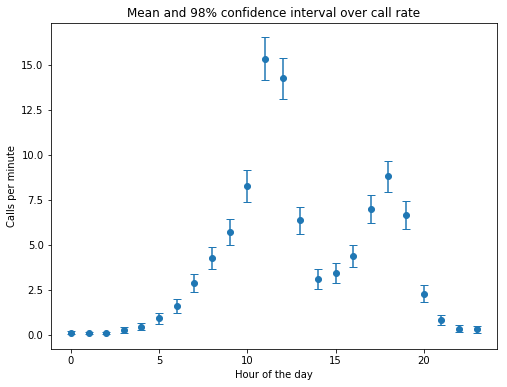

In [24]:
#plot the results of conf int calculation
hours=range(24)
#format confint into a 2xN array with lower and upper bounds separate
ci_lower=[posterior_means[i]-confidence_intervals[i][0] for i in range(24)]
ci_upper=[confidence_intervals[i][1]-posterior_means[i] for i in range(24)]
ci=[ci_lower,ci_upper] #join data

#get and plot posterior means by integration
plt.figure(figsize=(8, 6))
plt.errorbar(hours,posterior_means,yerr=ci, fmt='o',capsize=4)
plt.title("Mean and 98% confidence interval over call rate")
plt.xlabel('Hour of the day')
plt.ylabel('Calls per minute')
plt.savefig('errorbar.png', dpi=300)

Each dot on the graph illustrates an estimate of the rate of calls we might expect for the given hour of the day. We may observe that the busiest times of the day are 11:00-13:00 and 17:00-19:00. During these peak periods, the call center might receive more than 15 and 9 calls per minute, respectively. We see a lower rate (~3-7 calls/min) of calls between the peak periods, and during the night from 22:00-04:00 the center barely receives any calls.

The bars around each dot represent our certainty of the estimate. In fact they signal that we can be 98% certain that the true call rate for a given hour will be within the span of the bars. Thus the longer the bars, the greater is our uncertainty what the exact value of the call rate is going to be.


